# DSI-US-4 Project 2 Regression Challenge
For this project (our second of the class), we were asked to predict the price of homes at sale in Aimes, Iowa based on historical data. We were given two data sets - a training set and a prediction set. The instructors set up a Kaggle competition for all current DSI students where we were to submit our predictions. Below, I’ve tried to give an overview of each of the steps I took in cleaning up and evaluating the dataset as well as the modeling process. 

I made the decision early on to sacrifice explainability (e.g. limited number of predictors and their associated coefficients) and create a high variance, low bias model with many interaction features in order to derive as accurate of predictions as possible. Since time was not an issue, I thought it was ok to enter into the regularization portion of the process with as many features as possible. 

Although it took a long time for my model perform cross validation to determine the optimal alpha and L1 ratio to use (I used ElasticNet for my modeling), I’m happy to report that this approach enabled me to place first in the competition out of 80+ participants across the country! If you have any questions about this project or would like to reach out to discuss, please feel free to email me at joedorfman@gmail.com. I’d love to discuss this project and my approach with you!


In [1]:
#import
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet, LinearRegression, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
#read in datasets 
df = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [2]:
# explore training datasets
# df.describe()
# df.head()

In [4]:
# inspect features, data types, and missing values
# df.info()
# df.isnull().sum().sort_values(ascending=False)

Dataset contains 80 features and a target column of sale price. Some features have significant missing values or outliers which I will need to clean up. Below, I created a function to replace null values in Lot Frontage with a linear regression. I selected Lot Area and 1st Flr SF for my features in that regression. Initially, I got a low score and so I looked around online to see if anyone had encountered this before. I came across this website in my search: https://nycdatascience.com/blog/student-works/housing-prices-in-ames-iowa-kaggles-advanced-regression-competition/. They suggested taking the log of both the features and target for this exercise because that produced the most linear relationship. I updated my function with this suggestion and it returned a much higher score. I also visualized this below. In the first graphs before I took the logs, you can see that there is less of a linear relationship and presence of outliers. In the subsequent graphs, the outliers have been reduced and there is more of a linear relationship, especially between Lot Frontage and Lot Area. I will do something similar below with the target column as that distribution exhibits the qualities that warrant taking the log of the values.

Then I wrote another function to change the extreme outliers to reduce some affects later on with my scaling but decided against using it for this limited of a dataset. In the future, I would like to test the benefits of this function. 

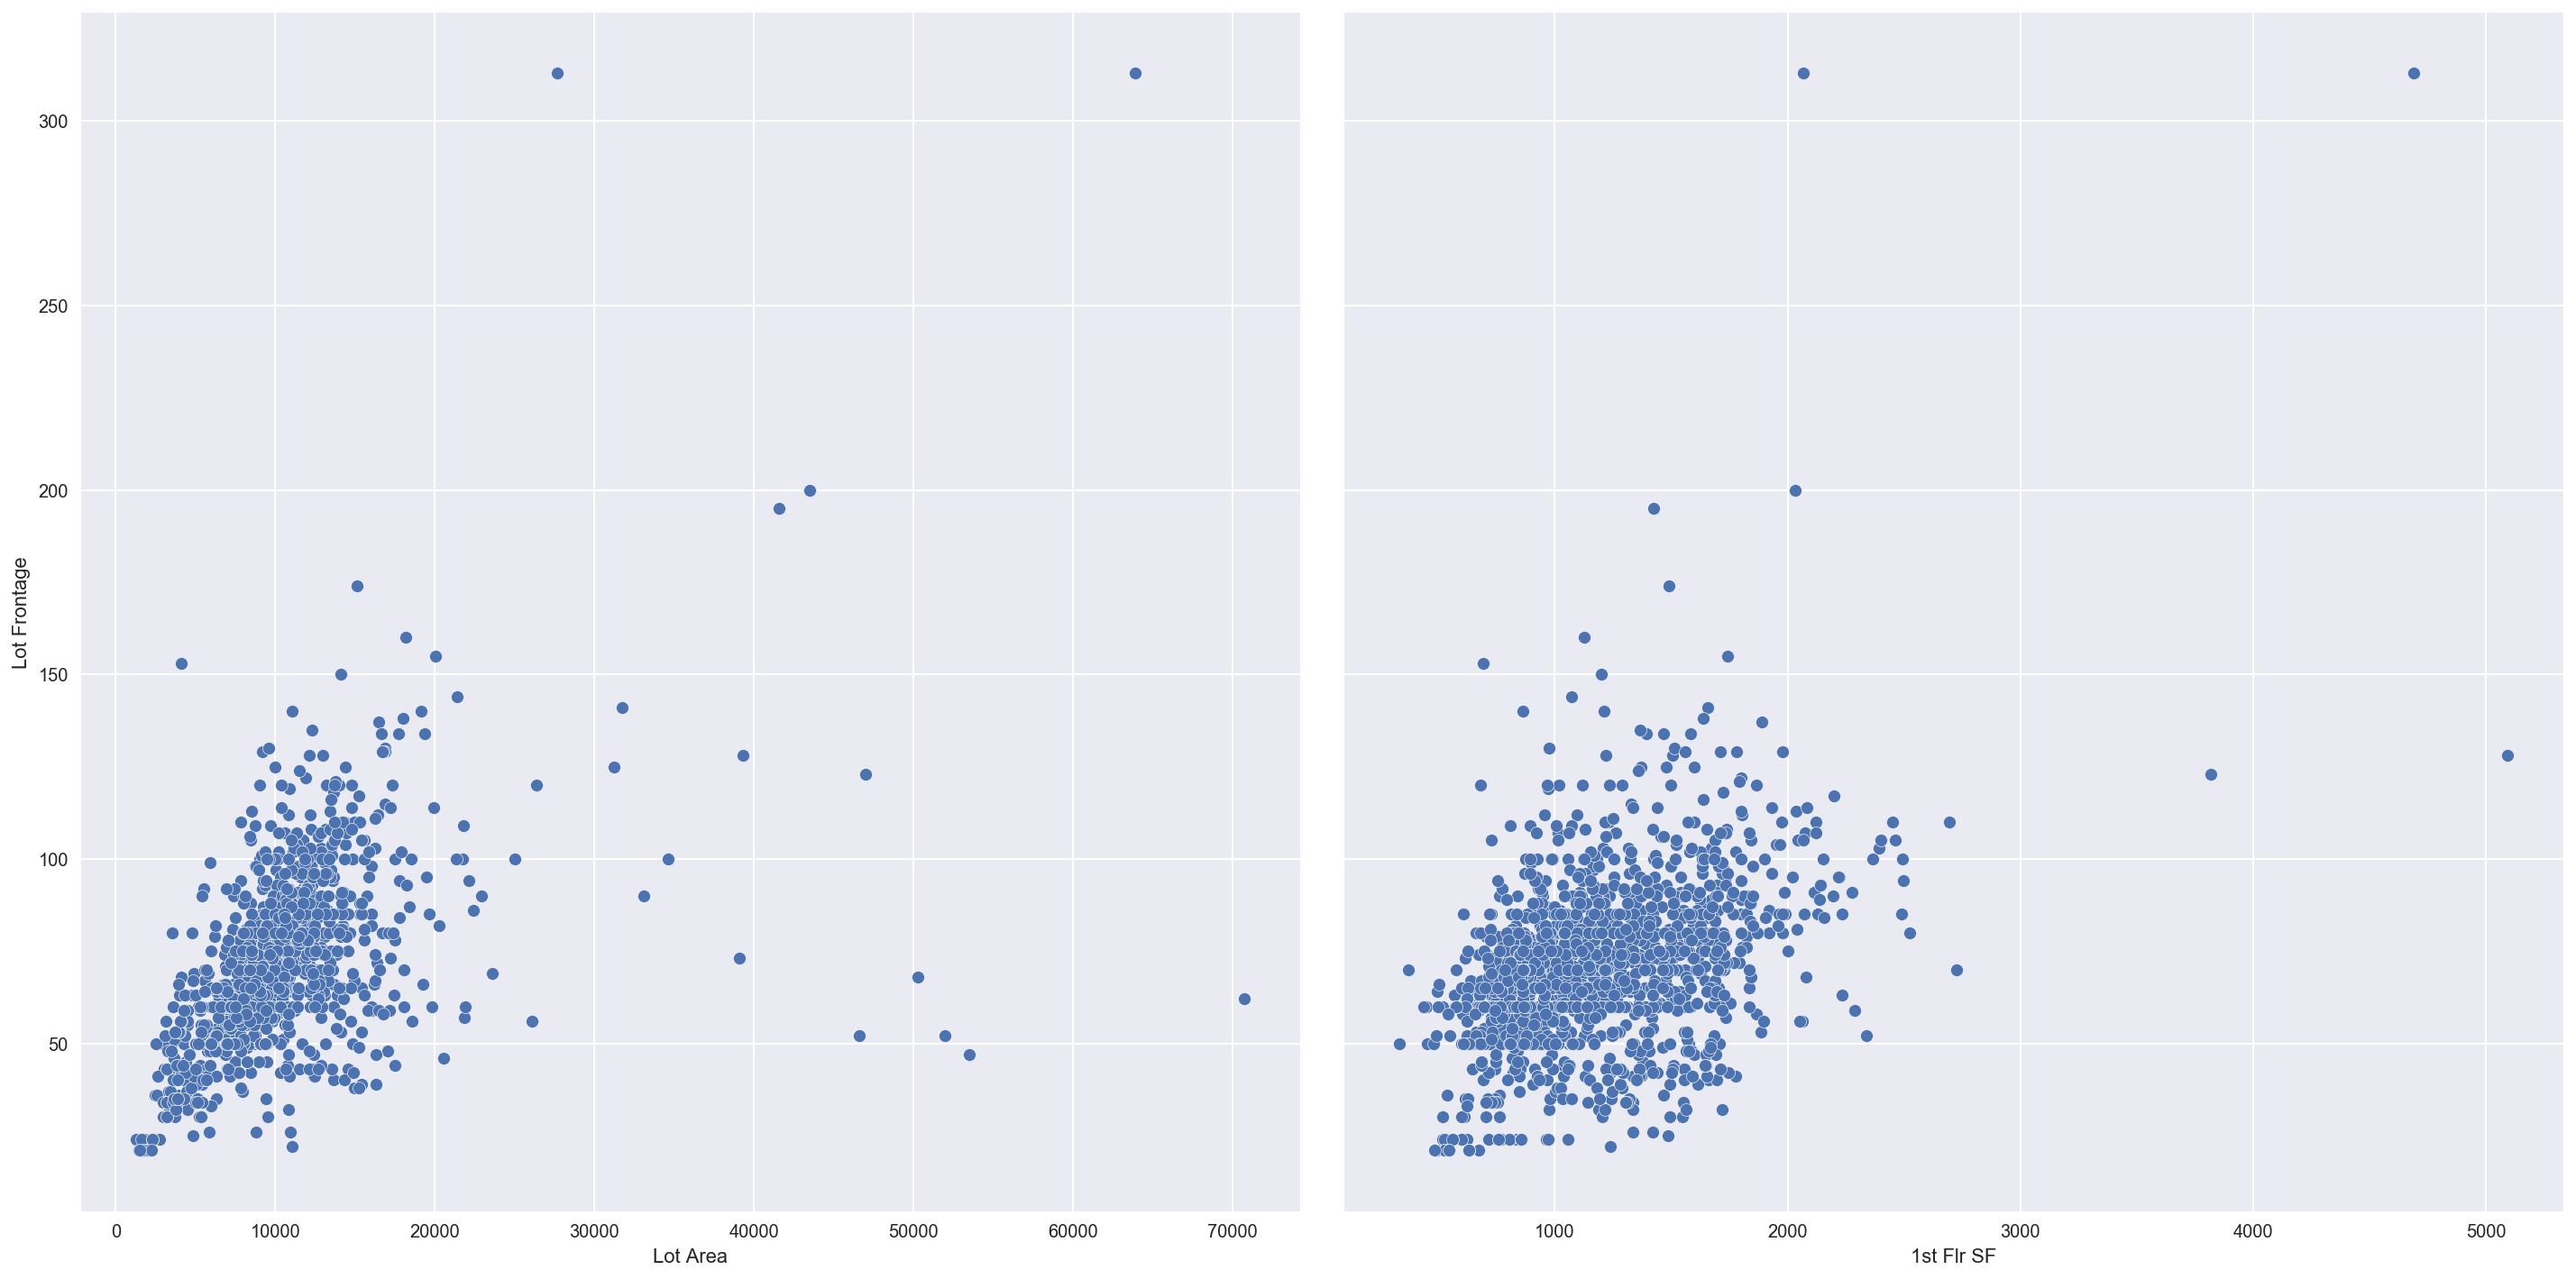

In [5]:
sns.pairplot(data=df, y_vars=['Lot Frontage'], x_vars=['Lot Area', '1st Flr SF'], size=10);

Lot Frontage vs Lot Area and 1st Flr SF. Not

In [6]:
log_frontage = np.log(df['Lot Frontage'])
log_area = np.log(df['Lot Area'])
log_1st = np.log(df['1st Flr SF'])

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


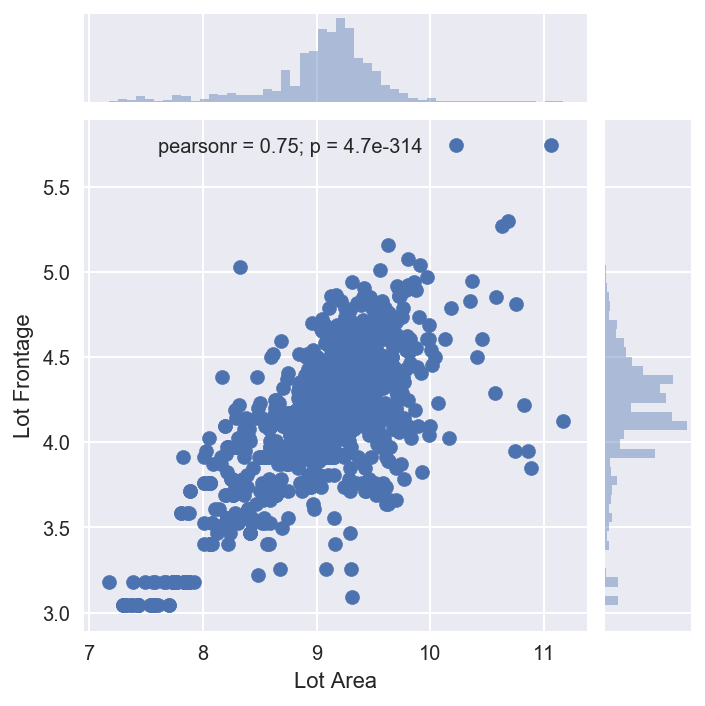

In [7]:
sns.jointplot(y=log_frontage, x=log_area, size=5);

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


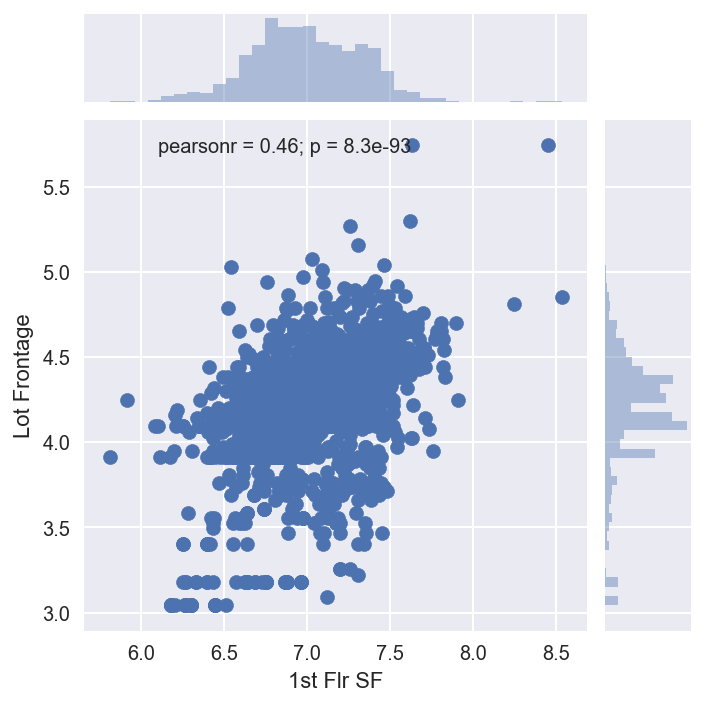

In [8]:
sns.jointplot(y=log_frontage, x=log_1st, size=5);

In [9]:
# def fill_lot_frontage(dataframe):
#     mask = dataframe['Lot Frontage'].isnull() #create mask with null values of Lot Frontage
    
#     #split data based on mask
#     X1 = dataframe[~mask] 
#     X2 = dataframe[mask]
    
#     #instantiate linear regression based on two highest correlated variables: Lot Area and 1st Flr SF
#     lr = LinearRegression()
#     X_lot_train = X1.loc[:, ['Lot Area', '1st Flr SF']]
#     y_lot_train = X1['Lot Frontage']
   
#     #fit model 
#     lr.fit(X_lot_train,y_lot_train)
    
#     #replace null values in Lot Frontage with 0's
#     dataframe['Lot Frontage'].fillna(0, inplace=True)
    
#     #iterate over each row, check if Lot Frontage is 0, replace with 
#     for i in range(len(dataframe)):
#         if dataframe['Lot Frontage'][i] == 0:
#             dataframe['Lot Frontage'][i] = lr.intercept_ + lr.coef_[0] * dataframe['Lot Area'][i] + lr.coef_[1]* dataframe['1st Flr SF'][i]
        

# fill_lot_frontage(df)
# fill_lot_frontage(test)

In [10]:
def fill_lot_frontage(dataframe):
    mask = dataframe['Lot Frontage'].isnull() #create mask with null values of Lot Frontage
    
    #split data based on mask
    X1 = dataframe[~mask] 
    X2 = dataframe[mask]
    
    #instantiate linear regression based on two highest correlated variables: Lot Area and 1st Flr SF
    lr = LinearRegression()
    X_lot_train = np.log(X1.loc[:, ['Lot Area', '1st Flr SF']])
    y_lot_train = np.log(X1['Lot Frontage'])
   
    #fit model 
    lr.fit(X_lot_train,y_lot_train)
    
    #replace null values in Lot Frontage with 0's
    dataframe['Lot Frontage'].fillna(0, inplace=True)
    
    #iterate over each row, check if Lot Frontage is 0, replace with 
    for i in range(len(dataframe)):
        if dataframe['Lot Frontage'][i] == 0:
            dataframe['Lot Frontage'][i] = np.exp(lr.intercept_ + lr.coef_[0] * np.log(dataframe['Lot Area'][i]) + lr.coef_[1]* np.log(dataframe['1st Flr SF'][i]))
        

fill_lot_frontage(df)
fill_lot_frontage(test)

/anaconda3/envs/dsi/lib/python3.6/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


I originally tried to have this function not have to interate through each row and change all null values at once but that was giving me some issues for some reason. I would like to work on this again so that I can run this function after a TTS (since it iterates over each row, I need to run this before removing any outliers).

In [11]:
assert df['Lot Frontage'].isnull().sum() == 0 & test['Lot Frontage'].isnull().sum()

In [12]:
# # function to change upper outliers for float columns that represent area (SF)
# def change_outliers(dataframe):                           
#     for i in dataframe.columns: #iterate through columns
#         if dataframe[i].name not in ['Garage Yr Blt', 'Garage Cars', 'Baths', 'Bsmt Baths', 'SalePrice']: 
#             if dataframe[i].dtype == float: #iterate through columns that are floats and outside of the list above
#                 for j in range(1,len(dataframe)): #iterate through each row to detect and change outliers 
#                     if dataframe.loc[j,i] > dataframe[i].mean() + (6*dataframe[i].std()):
#                         dataframe.loc[j,i] = dataframe[i].mean() + (6*dataframe[i].std())


# change_outliers(df)
# change_outliers(test)

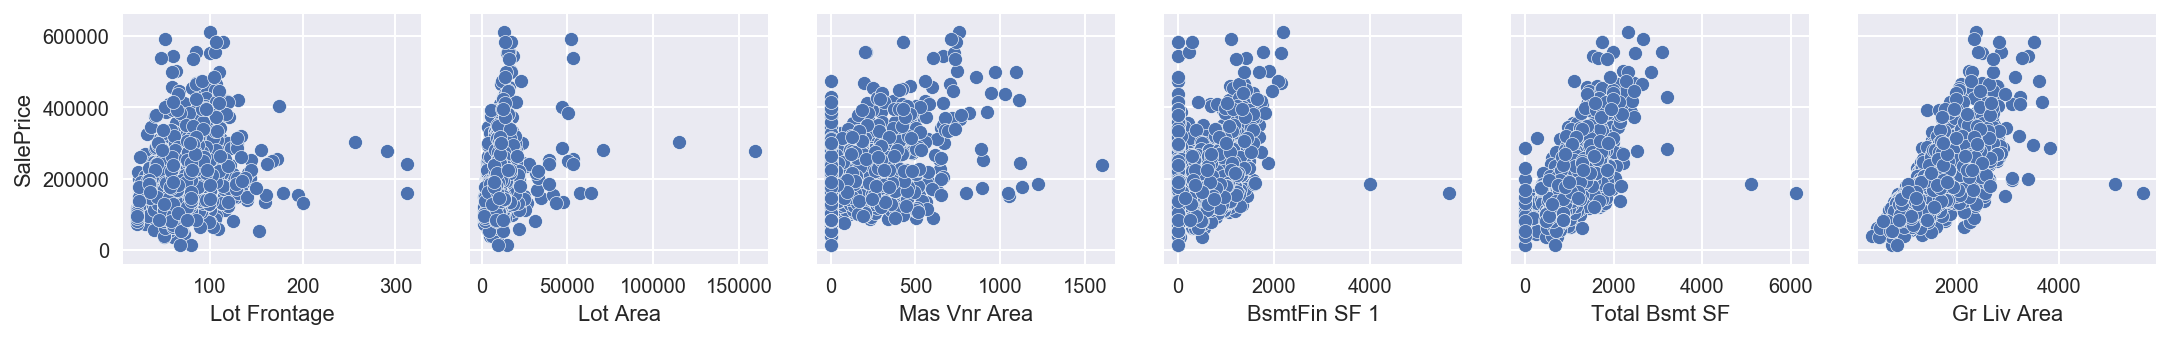

In [13]:
#inspect float columns representing areas (note, I plotted a few iterations of this to get to this set of columns)
sns.pairplot(data=df, y_vars=['SalePrice'], x_vars=['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 
                     'Total Bsmt SF', 'Gr Liv Area'],);

Clear outliers present above. Electing to remove them.

In [14]:
#drop obvious outliers
df.drop(df[df['Total Bsmt SF']>4000].index, inplace=True)
df.drop(df[df['Lot Frontage']>300].index, inplace=True)
df.drop(df[df['Lot Area']>100000].index, inplace=True)
df.drop(df[df['Mas Vnr Area']>1500].index, inplace=True)
df.drop(df[df['Gr Liv Area']>4000].index, inplace=True)
df.drop(df[df['BsmtFin SF 1']>3000].index, inplace=True)

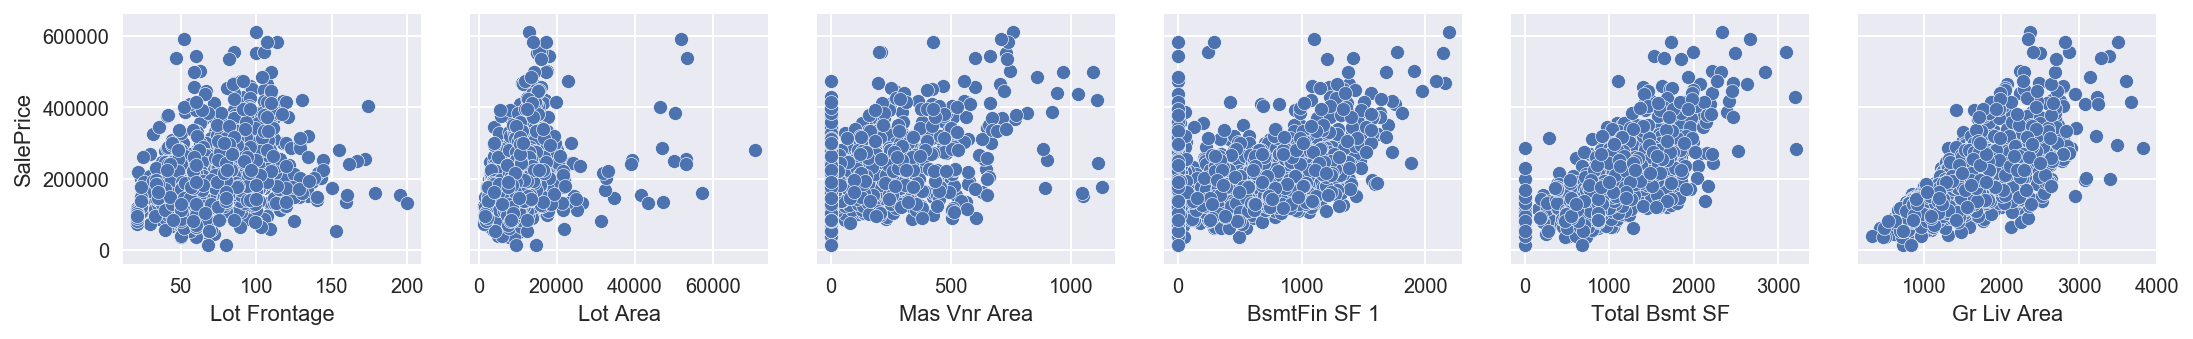

In [15]:
#inspect updates
sns.pairplot(data=df, y_vars=['SalePrice'], x_vars=['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 
                     'Total Bsmt SF', 'Gr Liv Area'],);

Updated distributions with outliers removed. Distributions now appear more linear, 0 values aside. 

In [16]:
# set X as all columns except for SalePrice and y as target of SalePrice
X = df.iloc[:, :80]
y = df['SalePrice']

In [17]:
# check for columns with null values 
# X.isnull().sum().sort_values(ascending=False).head(30)

Remaining null values are mostly in categorical features with datatype of objects. Will change these to 'NA' below

In [18]:
# fill categorical values with 'NA' as per information on kaggle

def fill_categoricals(dataframe): #function takes in dataframe so that I can run on both my train and test set
    for i in dataframe.columns: #iterate through column of the dataframe
        if dataframe[i].dtype == object: #check if the datatype is object
            dataframe[i].fillna('NA', inplace=True) #fill null values with 'NA'

fill_categoricals(X)
fill_categoricals(test)

Lastly, I will fill the remaining null values:

In [19]:
# for Garage Yr Blt, going to group by Year Built and take the mean. 
# since there will be some values as null after that,
# I am going to fill the remaining null value with the year built
# finally, going to fill the remaining null values with 0 

def fill_rest_nas(dataframe):
    dataframe['Garage Yr Blt'].fillna(dataframe.groupby(['Year Built'])['Garage Yr Blt'].transform('mean'), inplace=True)
    dataframe['Garage Yr Blt'].fillna(dataframe['Year Built'], inplace=True)
    dataframe.fillna(0, inplace=True)
    
fill_rest_nas(X)
fill_rest_nas(test)

In [20]:
assert X.isnull().sum().sum() == 0 & test.isnull().sum().sum() == 0

In [21]:
# I wanted to combine bathrooms for the house and basements
# Not sure if this affected anything but thought it was appropriate as this is usually how homes are sold

def combine_baths(dataframe):
    dataframe['Baths'] = dataframe['Full Bath'] + (dataframe['Half Bath']/2) #half baths listed as integer values
    dataframe['Bsmt Baths'] = dataframe['Bsmt Full Bath'] + (dataframe['Bsmt Half Bath']/2)
    dataframe.drop(['Full Bath', 'Half Bath','Bsmt Full Bath','Bsmt Half Bath'], axis=1, inplace=True) #drop columns after combining

combine_baths(X)
combine_baths(test)

Next, I created a function to dummy the categorical columns. For this, I needed to concatenate the training and prediction data, dummy the columns, and then split them up again. This was due to having different values in some of the features between datasets. 

In [22]:
# function to dummy columns that are type object
# needed to combine training and predicition set, dummy the columns, and split them up again
def get_dummied(train, test):
    list = ['MS SubClass'] #MS SubClass is the only feature I want to dummy that is not an object 
    for i in train.columns:
        if train[i].dtype == object:
            list.append(i) #create list of columns to dummy
            
    full_data = pd.concat([train, test], axis=0) #concatenate training and prediction data 
    full_data = pd.get_dummies(full_data, columns=list, drop_first=True) #dummy the list of columns
    
    #split data back out 
    X_dummied = full_data[:len(train)] 
    test_dummied = full_data[len(train):]

    return X_dummied, test_dummied 

Xd, testd = get_dummied(X, test)

In [23]:
assert Xd.shape[0] == X.shape[0] 
assert testd.shape[0] == test.shape[0]
assert Xd.shape[1] == testd.shape[1]

Now that my feature engineering is completed, I will move into modeling. Since I will be running elastic net cross validation below, I do not need to do any feature selection now. This will cause my model to take a long time to run, but will get me to the optimal set of features to use.

Before modeling I am going to take the log of the sale prices. As the distribution shows below, the majority of sale prices are located in the low end of the graph while higher prices constitute the tail of the distribution. By taking the log of the values, these qualities are reduced and the distribution becomes more normal. This will help in estimating the higher valued houses that would seem more like outliers without taking this approach. The second graph shows the updated distribution.

Later, I will have to take the exponential of the values after prediction.

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


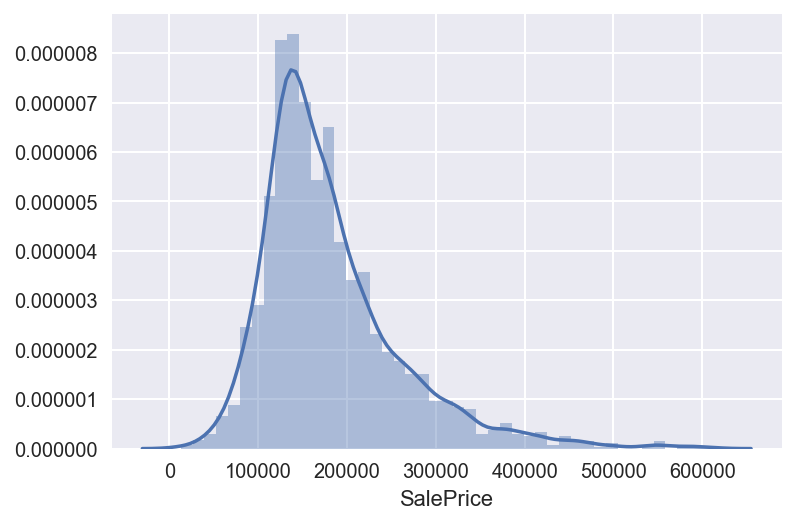

In [40]:
sns.distplot(df['SalePrice']);

/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


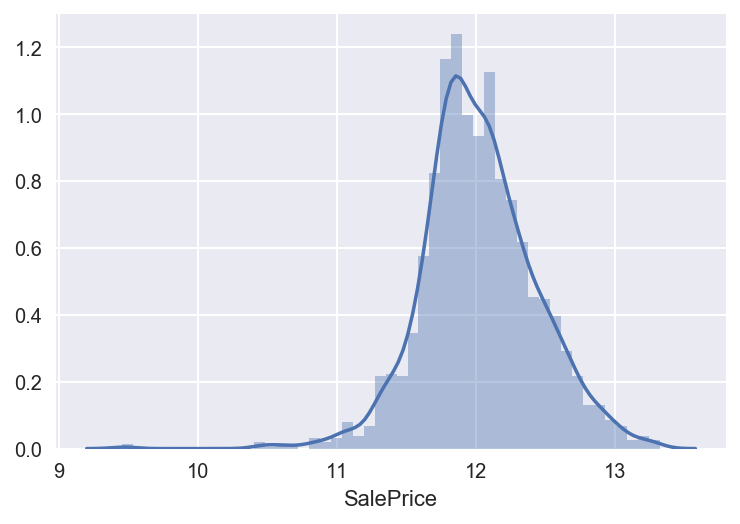

In [41]:
sns.distplot(np.log(df['SalePrice']))
plt.xlabel('Log Sale Price');

In [24]:
y = np.log(y) #take the log of sale prices

# create train and test sets from training data
X_train, X_test, y_train, y_test = train_test_split(Xd, y, test_size=0.2)

In [25]:
# get interaction and polynomial features
poly = PolynomialFeatures()
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [26]:
# use StandardScaler to standardize data
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train_poly)
X_test_scaled = ss.fit_transform(X_test_poly)


In [27]:
# use ElasticNetCV to find optimal alpha and L1 ratio
l1_ratios = np.linspace(0.01, 1.0, 25) #values to try for L1 ratio

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=3, #let elastic net try 100 values for alpha
                            selection='random') 
optimal_enet.fit(X_train_scaled, y_train)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

0.35214938797030776
0.01


Interestingly, after taking the log of the sale prices my L1 ratio went from 1 to .01. This is something I want to revisit to understand better. My thinking is that since the coefficients became much smaller due to the targets becoming much smaller, it was easier to completely zero them out. 

In [28]:
# create ElasticNet model
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

In [29]:
# fit model to training data and score against test set from TTS
enet.fit(X_train_scaled, y_train)

y_hat_test = enet.predict(X_test_scaled)

#need to take exponential of both prediction and test to score
y_hat_test = np.exp(y_hat_test)

print(r2_score(np.exp(y_test), y_hat_test))

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.9246258531631035


/anaconda3/envs/dsi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


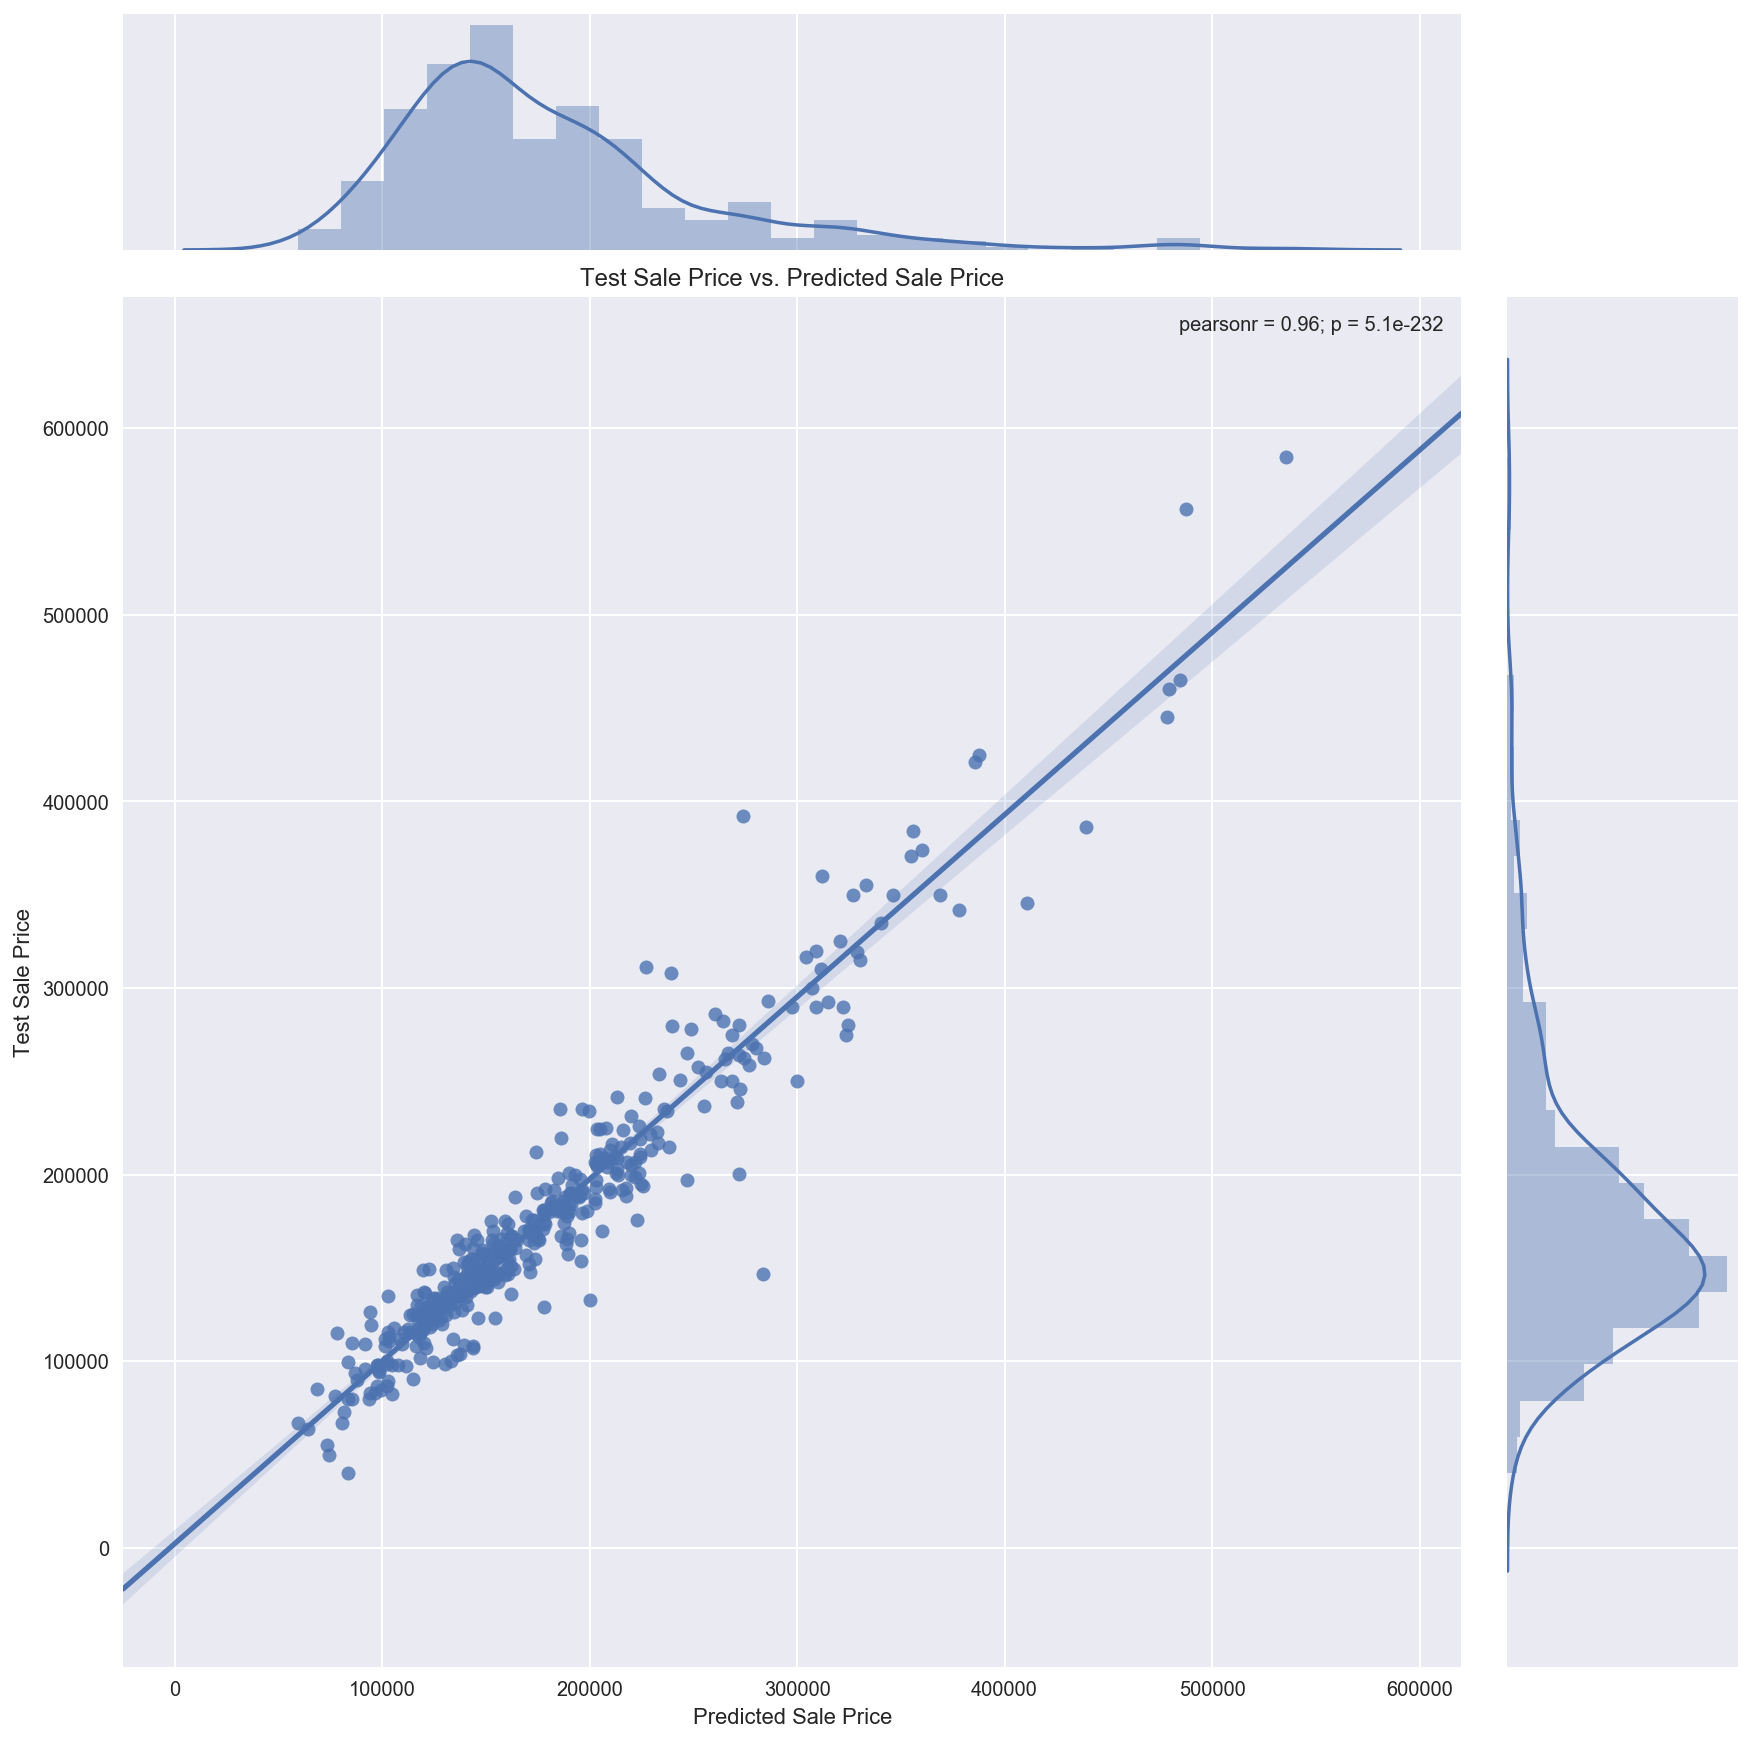

In [38]:
# plot predicted vs actuals
sns.jointplot(x=y_hat_test,y=np.exp(y_test), kind='reg', size=12)
plt.title('Test Sale Price vs. Predicted Sale Price')
plt.ylabel('Test Sale Price')
plt.xlabel('Predicted Sale Price');

Plot above showing Sale Prices from the test dataset of the TTS versus what the model predicted. 

In [31]:
# run polynomial features and StandardScaler on prediction data 
test_poly = poly.fit_transform(testd)
test_scaled = ss.fit_transform(test_poly)

In [32]:
# create SalePrice column of predicted values
test['SalePrice'] = np.exp(enet.predict(test_scaled)) #take exponential because predicting values based on log of sale prices

In [33]:
# create new dataframe to submit
submit = test[['Id','SalePrice']]
submit.set_index('Id', inplace=True)

In [34]:
#export submission data
submit.to_csv('./submit.csv')

In [37]:
#model information
print('intercept: ', enet.intercept_)
print(df['SalePrice'].mean())

#code from lab to see percent zeroed out
print('Percent variables zeroed out:', np.sum((enet.coef_ == 0))/float(X_train_poly.shape[1]))

#print # of features 
print('# of features:', X_train_poly.shape[1])
print('# of features after regularization:', np.sum(enet.coef_>0))

#code from lab to create dataframe of sorted features and their coefficients
enet_coefs = pd.DataFrame({'features':poly.get_feature_names(Xd.columns),
                            'coef':enet.coef_,
                            'abs_coef':np.abs(enet.coef_)})

enet_coefs.sort_values('abs_coef', inplace=True, ascending=False)

enet_coefs.head(25)

intercept:  12.026304719353643
181315.65183374082
Percent variables zeroed out: 0.9617960986382039
# of features: 40755
# of features after regularization: 711


,abs_coef,coef,features
1706,0.008698,0.008698,Overall Cond Gr Liv Area
13429,0.006982,-0.006982,MS Zoning_C (all) Heating QC_TA
1984,0.006829,0.006829,Year Built Gr Liv Area
1416,0.006703,0.006703,Overall Qual Overall Cond
1427,0.006700,0.006700,Overall Qual Gr Liv Area
17,0.006577,0.006577,Gr Liv Area
9771,0.006531,-0.006531,MS SubClass_30 Exter Cond_Fa
2261,0.006514,0.006514,Year Remod/Add Gr Liv Area
4929,0.006404,0.006404,Gr Liv Area Functional_Typ
4749,0.006333,0.006333,Gr Liv Area Street_Pave
